# Base Model (Linear Regression)
This base model will be used to benchmark subsequent ML/Non-ML models. This base model uses Muli-variate Linear Regression to predict the target course demand.

This model is trained on the Final Enrollment Status Data, which is a filtered version of the original Enrollment Dataset.

In [1]:
# importing the required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir( os.path.join("..", "..", "..") )

# importing custom modules
from Code.src.modules.db_ops import *
from Code.src.modules.dataManager import DataManager
from Code.src.modules.eda import *

# initializing the DataManager
DM = DataManager()

In [4]:
# importing the data for analysis
df = DM.get_data('EnrollmentFinalStatus', 'pkl', 'processed')
db = DM.get_data('EnrollmentFinalStatus', 'db', 'processed')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59409 entries, 0 to 323686
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rec_id               59409 non-null  int64         
 1   rec_ext_date         59409 non-null  datetime64[ns]
 2   file_name            59409 non-null  object        
 3   file_index           59409 non-null  int64         
 4   reg_term_code        59409 non-null  object        
 5   reg_term_year        59409 non-null  int64         
 6   reg_term_name        59409 non-null  category      
 7   reg_term_desc        59409 non-null  object        
 8   stu_id               59408 non-null  object        
 9   stu_deg_level        59409 non-null  category      
 10  stu_college          59409 non-null  category      
 11  stu_res              59409 non-null  category      
 12  stu_visa             59409 non-null  category      
 13  stu_bam              59409 non

In [3]:
df.columns

Index(['rec_id', 'rec_ext_date', 'file_name', 'file_index', 'reg_term_code',
       'reg_term_year', 'reg_term_name', 'reg_term_desc', 'stu_id',
       'stu_deg_level', 'stu_college', 'stu_res', 'stu_visa', 'stu_bam',
       'stu_new_ret', 'stu_dept', 'stu_dept_desc', 'stu_prog_code',
       'stu_prog_level', 'stu_prog_desc', 'stu_admit_term_code',
       'stu_admit_term_year', 'stu_admit_term_name', 'stu_admit_term_desc',
       'crs', 'crs_type', 'crs_credits', 'crs_hours', 'crs_sect',
       'crs_sect_clg', 'crs_sect_modality', 'crs_sect_wiley_ind', 'reg_status',
       'reg_status_date', 'stu_act_reg_ind'],
      dtype='object')

In [ ]:
db.runQuery("""--sql
    SELECT crs, 
""")

## Plotting the Course Demand for a course
The Course Demand is calculated as follows:
$$\rm{Course Demand} = \rm{Web Registered} + \rm{Registered} + \rm{Wait Listed}$$

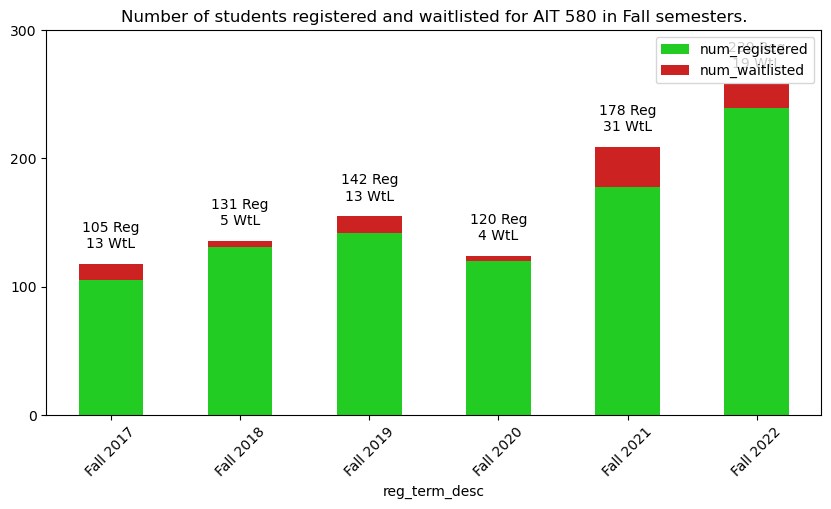

In [132]:
crs, term = "AIT 580", "Fall"
cond = "--" if term.lower() == "all" else ""

query = db.runQuery(f""" --sql
    SELECT
        reg_term_code, reg_term_desc, crs,
        COUNT(CASE WHEN reg_status IN ("**Web Registered**", "**Registered**") THEN 1 END) as num_registered,
        COUNT(CASE WHEN reg_status IN ("Wait Listed") THEN 1 END) as num_waitlisted
    FROM enrollmentFinalStatus
    WHERE
        crs = "{crs}"
        {cond} AND reg_term_name = "{term}"
        -- AND stu_prog_code IN ("VS-MS-DAEN", "EC-MS-DAEN")
    GROUP BY reg_term_code, reg_term_desc, crs;
""")

# Create a stacked bar chart to show the number of students registered and waitlisted for a course in a term
query.plot.bar(
    x="reg_term_desc", y=["num_registered", "num_waitlisted"],\
    stacked=True, figsize=(10, 5), rot=0, color=["#22cc22", "#cc2222"]
)
plt.yticks(range(0, query["num_registered"].max()+100, 100))
plt.xticks(rotation=45)

# Adding labels to each bar
for i, row in query.iterrows():
    plt.text(
        i, row["num_registered"]+row["num_waitlisted"]+10, 
        f"{row['num_registered']} Reg\n{row['num_waitlisted']} WtL", 
        ha="center", va="bottom"
    )

plt.title(f"Number of students registered and waitlisted for {crs} in {term} semesters.")
plt.show()

In [55]:
crs, term = "STAT 515", "Fall"

query = db.runQuery(f""" --sql
    SELECT reg_term_code, reg_term_desc, crs, COUNT(stu_id) as num_students
    FROM enrollmentFinalStatus
    WHERE
        crs = "{crs}"
        AND reg_term_name = "{term}"
        AND reg_status IN ("**Web Registered**", "**Registered**", "Wait Listed")
    GROUP BY reg_term_code, reg_term_desc;
""")

query

,reg_term_code,reg_term_desc,crs,num_students
0,201770,Fall 2017,STAT 515,84
1,201870,Fall 2018,STAT 515,111
2,201970,Fall 2019,STAT 515,156
3,202070,Fall 2020,STAT 515,125
4,202170,Fall 2021,STAT 515,198
5,202270,Fall 2022,STAT 515,218


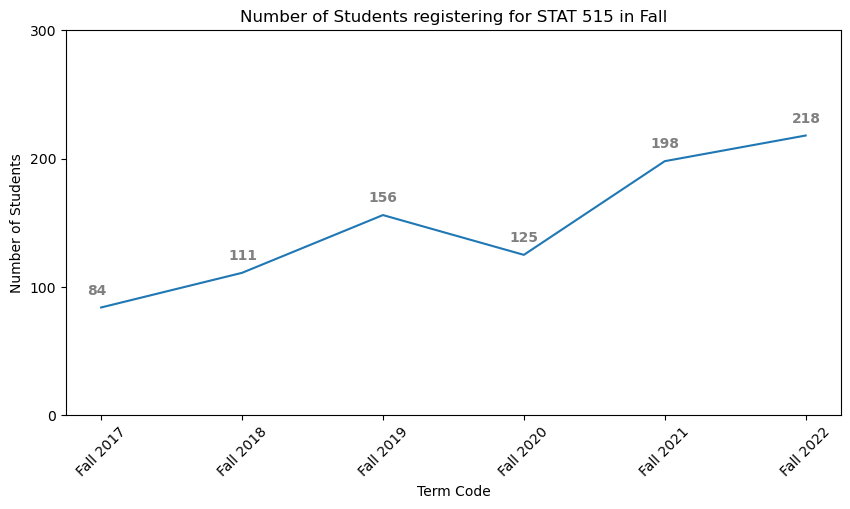

In [56]:
# Plotting the line graph for number of students in each term
plt.figure(figsize=(10, 5))
plt.plot(query["reg_term_code"], query["num_students"])

plt.xticks(rotation=90)
# Rounding the y-axis to the upper 100
plt.yticks(range(0, query["num_students"].max()+100, 100))

for i, v in enumerate(query["num_students"]):
    plt.text(i-0.1, v+10, str(v), color='grey', fontweight='bold')
plt.xticks(query["reg_term_code"], query["reg_term_desc"], rotation=45)
plt.title(f"Number of Students registering for {crs} in {term}")
plt.xlabel("Term Code")
plt.ylabel("Number of Students")

plt.show()

# Machine the shit out for Learning